In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


from network_handler import Network_Handler
from network import Network
from person import Person
from disease_propagator import Disease_Propagator
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Parameters
population_size = 1000
average_degree = 5
random_edge_probability = 0.1

time_limit = 1000
unit_time = population_size/10 # number of simulation steps that make up one time step

time_until_quarantine = {
    'mean': 4,
    'std_dev': 2
}
time_until_recovery = 10 # make distribution later
p = 0.1 # Factor for probability to become infected in public

Create our networks, first we create a base network, than the random reduction case and finally the triadic strategy case.

In [20]:
population_IDs = range(population_size)

# Network
# Degrees ranging from 3 to 10
# Clustering coefficient: between 0.15 and 0.2 
# Average shortest path length around 6
# -> Typical for social networks [Networks: An Introduction by Newman, my google sheet]

network_base = Network(population_size,average_degree,random_edge_probability)

# Init our networkhandler with the base_network we defined above
network_handler = Network_Handler(network_base)

# Randomly reduced network
network_randomly_reduced = network_handler.random_reduction()

# Reduced network with triadic strategy
network_triadic = network_handler.triadic_strategy()

network = {"base":network_base,
          "randomly_reduced":network_randomly_reduced,
          "triadic":network_triadic}

We can see that the different networks have different edges...

In [21]:
print(len(list(network_base.edges)))
print(len(list(network_randomly_reduced.edges)))
print(len(list(network_triadic.edges))) 

2000
1314
1283


 Next we create a dict for our susceptibles, infectious and quarantined. This has to be done for every network.

In [5]:
population = network_base.get_population()
#Population should be the same -> so that is not necessary  atm but maybe helpfull in the future
S = {"base": list(network_base.get_population().keys()),
     "randomly_reduced": list(network_randomly_reduced.get_population().keys()),
     "triadic": list(network_triadic.get_population().keys())
    }

#Initialize compartment ID lists
first_infected = random.choice(list(population.values()))
first_infected.time_to_quarantine = np.random.normal(time_until_quarantine['mean'], time_until_quarantine['std_dev'])

# Infectious
I = {"base": [first_infected.ID],
     "randomly_reduced": [first_infected.ID],
     "triadic": [first_infected.ID]
    }
for key in S.keys():
    S[key].remove(first_infected.ID)

Q = {} # Quarantined
for key in S.keys():
    Q[key] = []


In [6]:
#Loop over every of our networks... maybe implement that into the network handler
S_t = {}
I_t = {}
for key in S.keys():
    disease = Disease_Propagator(time_limit, time_until_quarantine['mean'], time_until_quarantine['std_dev'])
    S_t[key], I_t[key] = disease.simulate(network[key], S[key], I[key], Q[key], time_until_recovery, p)

Both the suceptible and infectious are highly correlated maybe only plot one of both (todo)

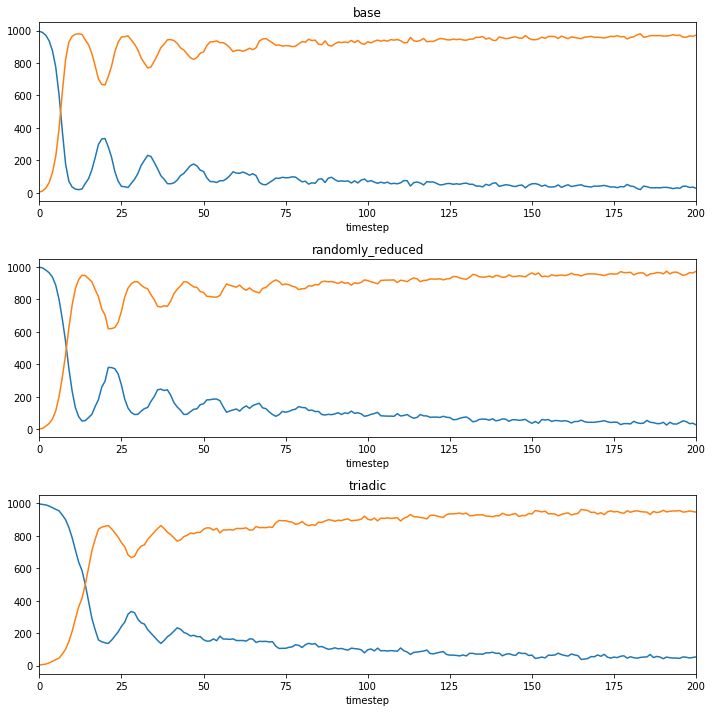

In [17]:
time_range = np.arange(0, time_limit, 1)
fig,ax = plt.subplots(3,1,figsize=(10,10))

for i,key in enumerate(S):
    ax[i].set_title(key)
    ax[i].set_xlabel("timestep")
    ax[i].set_xlim(0,200)
    ax[i].plot(time_range, S_t[key])
    ax[i].plot(time_range, I_t[key])
plt.tight_layout()

In [10]:
# just some general testing
network1 = nx.Graph()
network1.add_nodes_from([1,2])
network1.add_edge(1,2)
network2 = network1.copy()
network2.remove_edge(1,2)
network1.edges()
ls = list(network1.edges)


TypeError: remove_edge() missing 1 required positional argument: 'v'